# Implementing a Basic R-CNN object detection pipeline.

Using Dog dataset consisting of 157 images.

In [1]:
# define the base path to the *original* input dataset and then use
# the base path to derive the image and annotations directories
import os
import cv2
ORIG_BASE_PATH = "dog"
ORIG_IMAGES = "dog/images"
ORIG_ANNOTS = "dog/annotations"
print(ORIG_IMAGES, ORIG_ANNOTS)

# define the base path to the *new* dataset after running our dataset
# builder scripts and then use the base path to derive the paths to
# our output class label directories
BASE_PATH = "dataset"
POSITVE_PATH = "dataset/dog"
NEGATIVE_PATH = "dataset/no_dog"

# define the number of max proposals used when running selective
# search for (1) gathering training data and (2) performing inference
MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

# define the maximum number of positive and negative images to be
# generated from each image
MAX_POSITIVE = 30
MAX_NEGATIVE = 10

# initialize the input dimensions to the network
INPUT_DIMS = (224, 224)
# define the path to the output model and label binarizer
MODEL_PATH = "dog_detector.h5"
ENCODER_PATH = "label_encoder.pickle"
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.25

dog/images dog/annotations


In [2]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [3]:
#import packages
from bs4 import BeautifulSoup
from imutils import paths

for dirPath in (POSITVE_PATH, NEGATIVE_PATH):
    print(dirPath)
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)


imagePaths = list(paths.list_images(ORIG_IMAGES))

totalPositive = 0
totalNegative = 0

for (i, imagePath) in enumerate(imagePaths):
    print('[INFO] processing image {}/{}...'.format(i+1, len(imagePaths)))

    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([ORIG_ANNOTS, "{}.xml".format(filename)])

    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []

    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    # Get Gt value from XML file
    for o in soup.find_all("object"):
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)

        gtBoxes.append((xMin, yMin, xMax, yMax)) # Gt list

    image = cv2.imread(imagePath)

    #Image segmentation in progress
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects =[]

    for (x,y,w,h) in rects:
        proposedRects.append((x, y, x + w, y + h))

    positiveROIs = 0 # Image where the detection target exists
    negativeROIs = 0 # Image where the detection target does not exist

    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        for gtBox in gtBoxes:
            iou = compute_iou(gtBox, proposedRect) # iou calculation
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

            roi = None
            outputPath = None

            if iou > 0.7 and positiveROIs <= MAX_POSITIVE:

                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalPositive)
                outputPath = os.path.sep.join([POSITVE_PATH, filename])

                positiveROIs += 1
                totalPositive += 1

            # True if the suggested Region is inside gt, otherwise False
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY

            if not fullOverlap and iou < 0.05 and negativeROIs <= MAX_NEGATIVE:

                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalNegative)
                outputPath = os.path.sep.join([NEGATIVE_PATH, filename])

                negativeROIs += 1
                totalNegative += 1

            if roi is not None and outputPath is not None:
                roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)
                

dataset/dog
dataset/no_dog
[INFO] processing image 1/152...
[INFO] processing image 2/152...
[INFO] processing image 3/152...
[INFO] processing image 4/152...
[INFO] processing image 5/152...
[INFO] processing image 6/152...
[INFO] processing image 7/152...
[INFO] processing image 8/152...
[INFO] processing image 9/152...
[INFO] processing image 10/152...
[INFO] processing image 11/152...
[INFO] processing image 12/152...
[INFO] processing image 13/152...
[INFO] processing image 14/152...
[INFO] processing image 15/152...
[INFO] processing image 16/152...
[INFO] processing image 17/152...
[INFO] processing image 18/152...
[INFO] processing image 19/152...
[INFO] processing image 20/152...
[INFO] processing image 21/152...
[INFO] processing image 22/152...
[INFO] processing image 23/152...
[INFO] processing image 24/152...
[INFO] processing image 25/152...
[INFO] processing image 26/152...
[INFO] processing image 27/152...
[INFO] processing image 28/152...
[INFO] processing image 29/152

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle


# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))
#print(imagePaths)
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [5]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
    # construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

[INFO] compiling model...
[INFO] training head...


C:\Users\ASUS\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
78/78 [==============================] - 57s 695ms/step - loss: 0.2309 - accuracy: 0.9401 - val_loss: 0.0295 - val_accuracy: 0.9984
Epoch 2/5
78/78 [==============================] - 55s 705ms/step - loss: 0.0456 - accuracy: 0.9935 - val_loss: 0.0125 - val_accuracy: 0.9984
Epoch 3/5
78/78 [==============================] - 53s 678ms/step - loss: 0.0243 - accuracy: 0.9968 - val_loss: 0.0090 - val_accuracy: 0.9968
Epoch 4/5
78/78 [==============================] - 53s 680ms/step - loss: 0.0248 - accuracy: 0.9935 - val_loss: 0.0074 - val_accuracy: 0.9968
Epoch 5/5
78/78 [==============================] - 52s 664ms/step - loss: 0.0167 - accuracy: 0.9984 - val_loss: 0.0059 - val_accuracy: 0.9968
[INFO] evaluating network...
              precision    recall  f1-score   support

         dog       0.99      1.00      1.00       292
      no_dog       1.00      0.99      1.00       335

    accuracy                           1.00       627
   macro avg       1.00      1.00      1.00

C:\Users\ASUS\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


[INFO] saving label encoder...


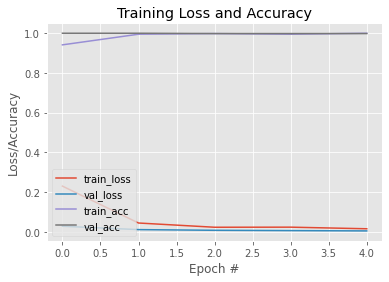

In [6]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
    
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [7]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return the indexes of only the bounding boxes to keep
    return pick
    

In [8]:
# import the necessary packages
from tensorflow.keras.models import load_model
import imutils

img_path="dog/images/n02085620_3677.jpg"
#img_path1="dog/images/n02085620_1271.jpg"
#img_path2="dog/images/n02085620_952.jpg"


# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())
# load the input image from disk
image = cv2.imread(img_path)
image = imutils.resize(image, width=500)
#image1 = cv2.imread(img_path1)
#image1 = imutils.resize(image1, width=500)
#image2 = cv2.imread(img_path2)
#image2 = imutils.resize(image2, width=500)
# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
#ss.setBaseImage(image1)
#ss.setBaseImage(image2)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] loading model and label binarizer...
[INFO] running selective search...


In [9]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:MAX_PROPOSALS_INFER]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, INPUT_DIMS,interpolation=cv2.INTER_CUBIC)
    
#    roi1 = image1[y:y + h, x:x + w]
#    roi1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2RGB)
#    roi1 = cv2.resize(roi1, INPUT_DIMS,interpolation=cv2.INTER_CUBIC)
    
#    roi2 = image2[y:y + h, x:x + w]
#    roi2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2RGB)
#    roi2 = cv2.resize(roi2, INPUT_DIMS,interpolation=cv2.INTER_CUBIC)
        
    
    
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    
#    roi2 = img_to_array(roi2)
#    roi2 = preprocess_input(roi2)
    
#    roi1 = img_to_array(roi1)
#    roi1 = preprocess_input(roi1)
     # update our proposals and bounding boxes lists
    proposals.append(roi)
    #proposals.append(roi1)
    #proposals.append(roi2)
    boxes.append((x, y, x + w, y + h))

# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)
print(proba)

[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...
[[1.31964441e-06 9.99998689e-01]
 [8.81060487e-07 9.99999166e-01]
 [4.93689049e-06 9.99995112e-01]
 [6.21426068e-07 9.99999404e-01]
 [2.44773651e-06 9.99997497e-01]
 [5.97458936e-08 9.99999881e-01]
 [4.07948519e-09 1.00000000e+00]
 [2.66479146e-05 9.99973297e-01]
 [4.89835083e-01 5.10164917e-01]
 [9.99948740e-01 5.12154838e-05]
 [1.16287538e-06 9.99998808e-01]
 [9.37630612e-05 9.99906182e-01]
 [5.30871293e-05 9.99946952e-01]
 [7.30385364e-05 9.99926925e-01]
 [1.23137538e-03 9.98768628e-01]
 [1.13580256e-07 9.99999881e-01]
 [1.76104822e-05 9.99982357e-01]
 [6.65084258e-07 9.99999285e-01]
 [7.24083066e-07 9.99999285e-01]
 [2.75766240e-07 9.99999762e-01]
 [4.65973717e-05 9.99953389e-01]
 [9.49386895e-01 5.06131463e-02]
 [8.14639733e-08 9.99999881e-01]
 [2.79018224e-07 9.99999762e-01]
 [4.20284877e-03 9.95797157e-01]
 [4.34542313e-09 1.00000000e+00]
 [8.30412205e-07 9.99999166e-01]
 [4.56339985e-01 5.43659985e-01]
 [

[INFO] applying NMS...


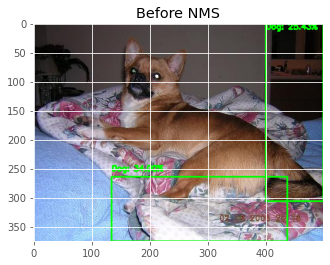

In [10]:
# find the index of all predictions that are positive for the
# "dog" class
print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "dog")[0]
# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]
# further filter indexes by enforcing a minimum prediction
# probability be met
idxs = np.where(proba >= MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Dog: {:.2f}%".format(prob * 100)
    cv2.putText(clone, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
plt.title("Before NMS")
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

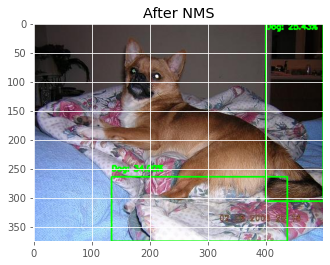

In [11]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)
# loop over the bounding box indexes
for i in boxIdxs:
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = boxes[i]
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Dog: {:.2f}%".format(proba[i] * 100)
    cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
plt.title("After NMS")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Results
- Result 1
<img src="dg1.1.png" height="400" width="400">

<img src="dg1.2.png" height="400" width="400">

- Result 2
<img src="dg2.1.png" height="400" width="400">

<img src="dg2.2.png" height="400" width="400">

Changed MIN PROB to 0.25 because model was not able to detect dog. Results shows model is detecting object correctly, but the boundry boxes are not wll placed.

# Implementing object detection using YOLOv3 pretrained on COCO dataset.

In [12]:
image_path = "dog/images/n02085620_952.jpg"
yolo_path ="yolo-coco"
conf = 0.5 #minimum probability to filter weak detections
thresh = 0.3 #threshold when applying non-maxima suppression
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([yolo_path, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([yolo_path, "yolov3.weights"])
configPath = os.path.sep.join([yolo_path, "yolov3.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [14]:
# load our input image and grab its spatial dimensions
import time
image = cv2.imread(image_path)
(H, W) = image.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.431423 seconds


In [15]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > conf:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

### Apply non-maxima suppression to suppress weak, overlapping bounding

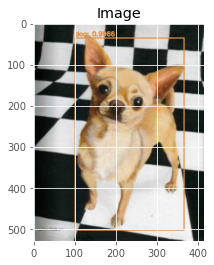

In [16]:
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf, thresh)

# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # show the output image
plt.title("Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Results
- Result 1
<img src="dog1.jpg" height="400" width="400">

- Result 2
<img src="dog2.jpg" height="400" width="400">


As it can be seen in results, YOLOv3 was successfully able to detect dog from the given images using pretrained COCO daraset.

# Implementing Instance Segmentation using Mask R-CNN with OpenCV.

In [17]:
# import the necessary packages
import numpy as np
import random
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

image_path = "dog/images/n02085620_730.jpg"
conf = 0.5
thresh = 0.3

In [18]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join(["mask_rcnn", "object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")
# load the set of colors that will be used when visualizing a given
# instance segmentation
colorsPath = os.path.sep.join(["mask_rcnn", "colors.txt"])
COLORS = open(colorsPath).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

In [19]:
# derive the paths to the Mask R-CNN weights and model configuration
# load our Mask R-CNN trained on the COCO dataset
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow("mask_rcnn/frozen_inference_graph.pb", "mask_rcnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

[INFO] loading Mask R-CNN from disk...


In [20]:
# load our input image and grab its spatial dimensions
image = cv2.imread(image_path)
(H, W) = image.shape[:2]
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box  coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 0.813703 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] masks shape: (100, 90, 15, 15)


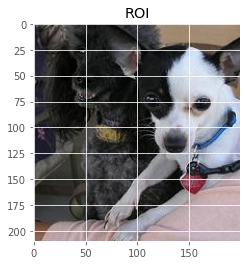

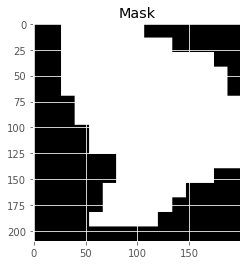

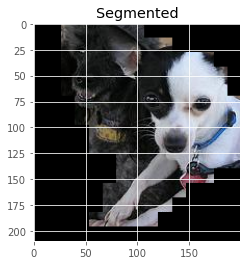

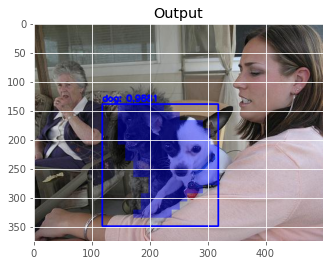

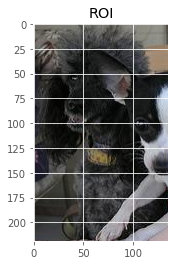

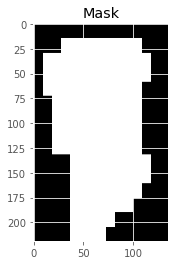

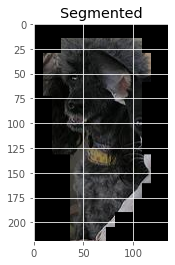

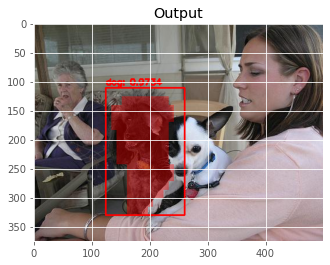

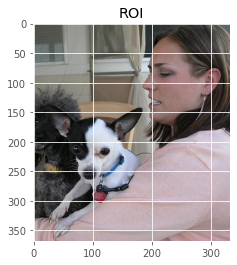

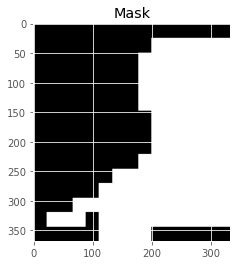

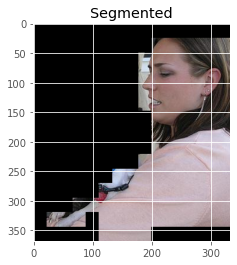

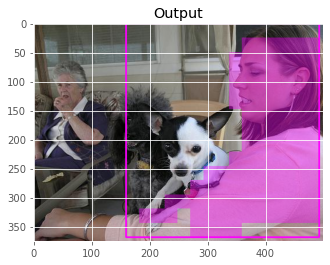

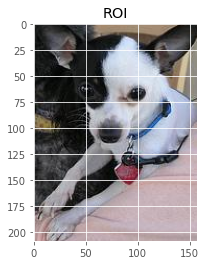

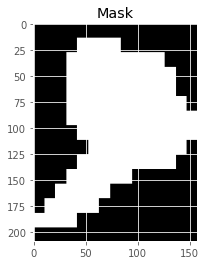

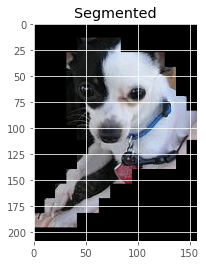

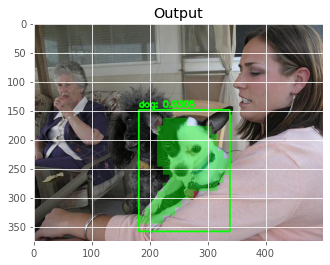

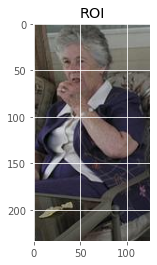

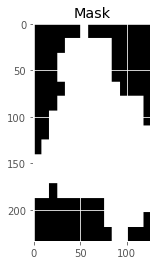

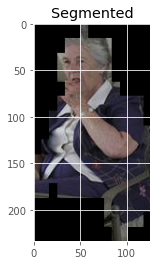

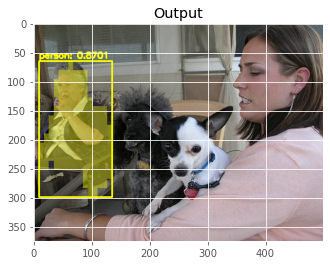

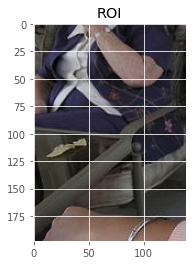

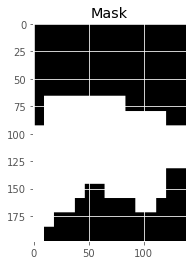

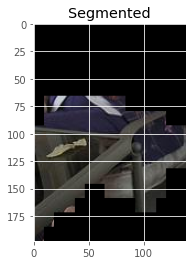

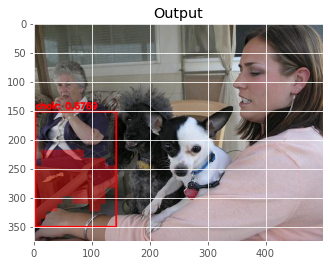

In [21]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
    # extract the class ID of the detection along with the confidence
    # (i.e., probability) associated with the prediction
    classID = int(boxes[0, 0, i, 1])
    confidence = boxes[0, 0, i, 2]
    # filter out weak predictions by ensuring the detected probability
    # is greater than the minimum probability
    if confidence > conf:
        # clone our original image so we can draw on it
        clone = image.copy()
        # scale the bounding box coordinates back relative to the
        # size of the image and then compute the width and the height
        # of the bounding box
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY
        
        # extract the pixel-wise segmentation for the object, resize
        # the mask such that it's the same dimensions of the bounding
        # box, and then finally threshold to create a *binary* mask
        mask = masks[i, classID]
        mask = cv2.resize(mask, (boxW, boxH),
            interpolation=cv2.INTER_NEAREST)
        mask = (mask > thresh)
        # extract the ROI of the image
        roi = clone[startY:endY, startX:endX]
        
        # check to see if are going to visualize how to extract the
        # masked region itself
       
        # convert the mask from a boolean to an integer mask with
        # to values: 0 or 255, then apply the mask
        visMask = (mask * 255).astype("uint8")
        instance = cv2.bitwise_and(roi, roi, mask=visMask)
        # show the extracted ROI, the mask, along with the
        # segmented instance
        plt.title("ROI")
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.show()
        
        plt.title("Mask")
        plt.imshow(cv2.cvtColor(visMask, cv2.COLOR_BGR2RGB))
        plt.show()
        
        plt.title("Segmented")
        plt.imshow(cv2.cvtColor(instance, cv2.COLOR_BGR2RGB))
        plt.show()

        # now, extract *only* the masked region of the ROI by passing
        # in the boolean mask array as our slice condition
        roi = roi[mask]
        # randomly select a color that will be used to visualize this
        # particular instance segmentation then create a transparent
        # overlay by blending the randomly selected color with the ROI
        color = random.choice(COLORS)
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")
        # store the blended ROI in the original image
        clone[startY:endY, startX:endX][mask] = blended
        
        # draw the bounding box of the instance on the image
        color = [int(c) for c in color]
        cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
        # draw the predicted label and associated probability of the
        # instance segmentation on the image
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(clone, text, (startX, startY - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        # show the output image
        plt.title("Output")
        plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
        plt.show()


# Results


- n02085620_1862.jpg
<img src="dd1.gif" height="200" width="200">

- n02085620_4998.jpg
<img src="dd2.gif" height="200" width="200">

- n02085620_3651.jpg
<img src="dd3.gif" height="200" width="200">

- n02085620_4572.jpg
<img src="dd4.gif" height="200" width="200">

The Instace segmentation first selects region of intrest from the image, then apply the mask , perform segmentation and gives output. It can be seen in the ruslts that for rach image it selcets diffrent ROIs , apply mask then segmentation and finally gives output by displaying boundry box aroung the object, object name and confidence. The Instace segmentation was able to successfully detect diffrent objects like dog, person , monitor , etc.